In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import torch
from sympy import Symbol, exp, log

/groups/icecube/qgf305/anaconda3/envs/graphnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""

    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                     for a in self.args)

    def __repr__(self):
       return '\n\n'.join(a + '\n' + repr(eval(a))
                       for a in self.args)

In [3]:
indir_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_stop_track_muon/Inference/pid_Leon_RD_results_new_model.csv"
indir_MC = "/groups/icecube/peter/storage/Multiclassification/Real/last_one_lvl3MC/dynedge_pid_Real_run_21.5_mill_equal_frac_second_/results.csv"
outdir = "/groups/icecube/qgf305/workspace/analyses/multi_classification_on_stop_and_track_muons/plotting/Comparison_RD_MC/test"

results_RD = pd.read_csv(indir_RD, index_col=[0])
results_MC = pd.read_csv(indir_MC, index_col=[0])

In [4]:
display("results_RD", "results_MC")

,pid_noise_pred,pid_muon_pred,pid_neutrino_pred,pid,event_no
0,9.100197e-04,0.995220,3.870316e-03,-1.0,0.0
1,1.982298e-17,0.999997,3.332041e-06,-1.0,1.0
2,2.132605e-12,0.999917,8.263976e-05,-1.0,2.0
3,2.653166e-14,0.999795,2.045055e-04,-1.0,3.0
4,9.950417e-01,0.000308,4.650586e-03,-1.0,4.0
...,...,...,...,...,...
1420704,9.957962e-01,0.000621,3.582841e-03,-1.0,96917756.0
1420705,2.507694e-17,1.000000,4.941842e-07,-1.0,96917757.0
1420706,1.000000e+00,0.000000,0.000000e+00,-1.0,96917758.0
1420707,9.853759e-01,0.001128,1.349629e-02,-1.0,96917759.0


In [5]:
print("unique pids before transform: ", np.unique(results_MC.pid))
class_options = {1: 0, -1: 0, 13: 1, -13: 1, 12: 2, -12: 2, 14: 2, -14: 2, 16: 2, -16: 2}
pid_transform = torch.tensor([class_options[int(value)] for value in results_MC["pid"]])
print("length: ", len(pid_transform))
pid_transform

unique pids before transform:  [-16. -14. -12.  -1.  12.  13.  14.  16.]
length:  7425000


tensor([0, 1, 1,  ..., 2, 2, 1])

In [6]:
def logit_transform(p, eps=1e-6, inverse=False):
    if np.isnan(p):
        return
    p = p*(1-2*eps)+eps
    try:
        if inverse:
            transform = np.exp(p) / (1 + np.exp(p))
        else:
            transform = np.log(p)- np.log(1 -p)
    except ZeroDivisionError as e:
        print(e)

    return transform

In [7]:
keys = ["noise", "muon", "neutrino"]
noise_logits, muon_logits, neutrino_logits = dict(), dict(), dict()
mask = dict()
# loop over dataset
for key in keys:
    # loop over noise/particle type
    for class_type, item in enumerate(keys):
        mask[item] = results_MC[f'pid_{key}_pred'].where(pid_transform == class_type)
        # applies function elementwise and writes to item in loop e.g. "noise_logits"
        locals()[f"{key}_logits"][item] = pd.Series(mask[item]).apply(logit_transform)
    locals()[f"{key}_logits"]["RD"] = pd.Series(results_RD[f'pid_{key}_pred']).apply(logit_transform)

In [8]:
for key in keys:
    # loop over noise/particle type
    for class_type, item in enumerate(keys):
        print(f"{key} prediction for {item} logit: ",eval(f"{key}_logits")[item].max(), eval(f"{key}_logits")[item].min())

noise prediction for noise logit:  13.81550955804604 -11.841907165403866
noise prediction for muon logit:  7.218115617865962 -13.815509557963773
noise prediction for neutrino logit:  7.9910569495195425 -13.815509557963773
muon prediction for noise logit:  5.42103538966023 -13.815509557963773
muon prediction for muon logit:  13.81550955804604 -13.384398334470275
muon prediction for neutrino logit:  13.81550955804604 -13.815509557963773
neutrino prediction for noise logit:  10.411387004006823 -13.815509557963773
neutrino prediction for muon logit:  13.34798010763727 -13.81550947680503
neutrino prediction for neutrino logit:  13.81550955804604 -13.8032699023568


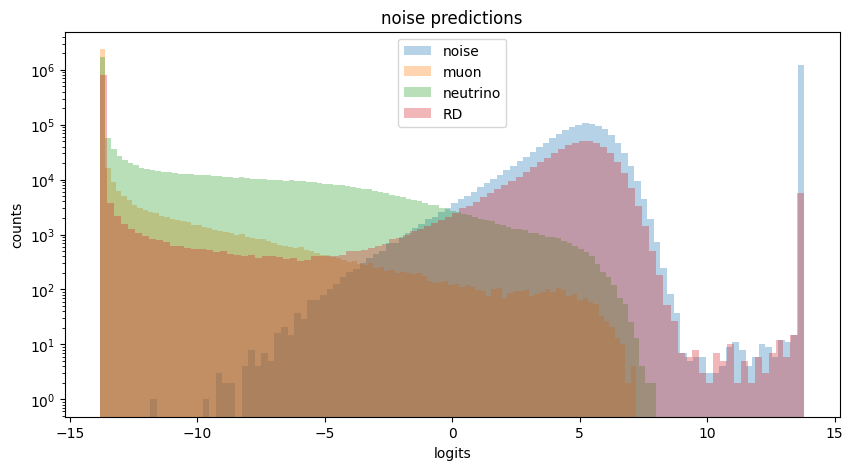

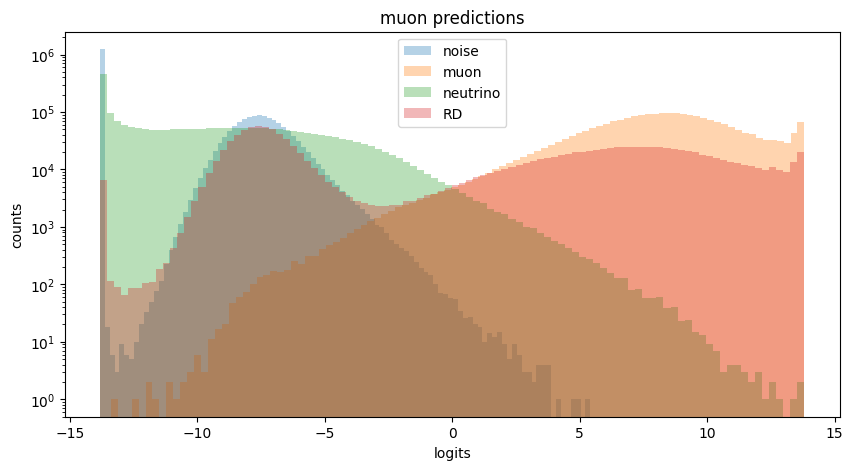

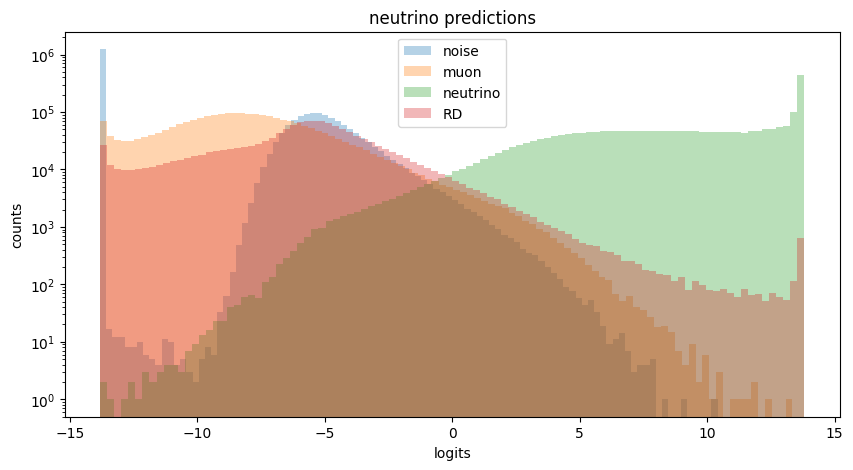

In [9]:

# loop over dataset
bin_value, bins = dict(), dict() 
for key in keys:
    fig, ax = plt.subplots(figsize=[10, 5])
    # loop over noise/particle type
    for class_type, item in enumerate(keys):
        bin_value[item], bins[item], _ = ax.hist(eval(f"{key}_logits")[item], bins=100, alpha=0.33, label=item);
    ax.set_title(f"{key} predictions")
    ax.set_xlabel("logits")
    ax.set_ylabel("counts")
    ax.hist(eval(f"{key}_logits")["RD"], bins=100, alpha=0.33, label="RD")
    ax.set(yscale="log")
    ax.legend();

In [11]:
for key in keys:
    # preallocations of temporary variables
    stds, means, means_realdata_diff = dict(), dict(), dict()

    # loop over noise/particle type and real data
    for class_type, item in enumerate(keys + ["RD"]):
        # take pandas standard deviation and mean and write into preallocated variable
        stds[item] = eval(key+"_logits")[item].std()
        means[item] = eval(key+"_logits")[item].mean()
        means_realdata_diff[item] = eval(key+"_logits")[item].mean() - eval(key+"_logits")["RD"].mean()

    # convert back into dataframe
    stds = pd.DataFrame.from_dict(stds, orient='index', columns=['std'])
    means = pd.DataFrame.from_dict(means, orient='index', columns=['mean'])
    means_realdata_diff = pd.DataFrame.from_dict(means_realdata_diff, orient='index', columns=['diff_realdata_mean'])

    # concatenate into metrics variable
    locals()["metrics_"+key] = pd.concat([stds,means, means_realdata_diff],axis=1)

    # delete temporary variables
    del stds, means, means_realdata_diff

display("metrics_noise", "metrics_muon", "metrics_neutrino")

,std,mean,diff_realdata_mean
noise,4.700088,9.256103,15.525815
muon,0.960504,-13.686823,-7.417112
neutrino,3.409984,-12.222320,-5.952608
RD,9.098534,-6.269711,0.000000
,std,mean,diff_realdata_mean
noise,3.319189,-10.619669,-11.644853
muon,3.133949,8.089504,7.064320
neutrino,3.883315,-9.229240,-10.254424
RD,7.651440,1.025184,0.000000
,std,mean,diff_realdata_mean


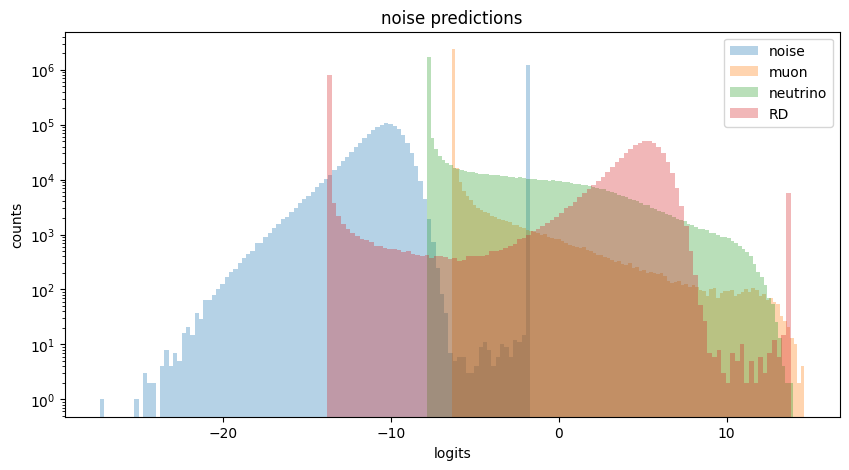

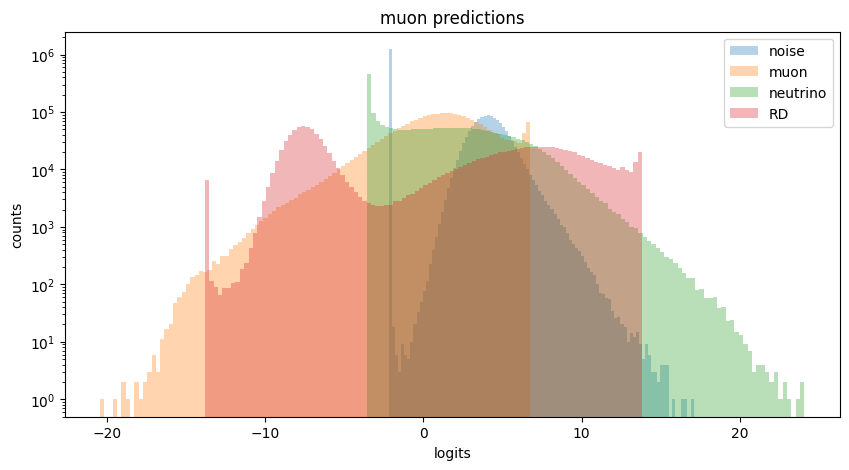

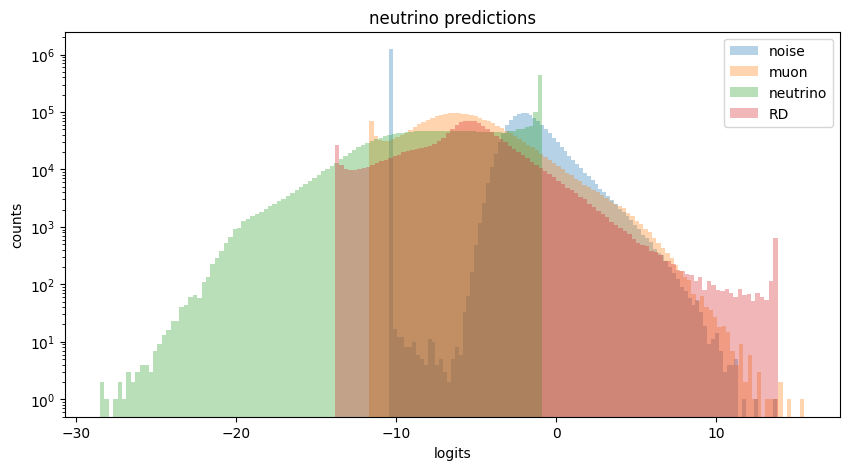

In [12]:
# loop over dataset
bin_value, bins = dict(), dict() 
for key in keys:
    fig, ax = plt.subplots(figsize=[10, 5])
    # loop over noise/particle type
    for class_type, item in enumerate(keys):
        bin_value[item], bins[item], _ = ax.hist(eval(f"{key}_logits")[item]-eval(f"metrics_{key}")["diff_realdata_mean"][item], bins=100, alpha=0.33, label=item);
    ax.set_title(f"{key} predictions")
    ax.set_xlabel("logits")
    ax.set_ylabel("counts")
    ax.hist(eval(f"{key}_logits")["RD"], bins=100, alpha=0.33, label="RD")
    ax.set(yscale="log")
    ax.legend();

In [16]:
keys = ["noise", "muon", "neutrino"]
noise_probability, muon_probability, neutrino_probability = dict(), dict(), dict()
mask = dict()
# loop over dataset
for key in keys:
    # loop over noise/particle type
    for class_type, item in enumerate(keys):
        mask[item] = eval(f"{key}_logits")[item]-eval(f"metrics_{key}")["diff_realdata_mean"][item]
        # applies function elementwise and writes to item in loop e.g. "noise_logits"
        locals()[f"{key}_probability"][item] = pd.Series(mask[item]).apply(lambda x: logit_transform(x,inverse=True))
    locals()[f"{key}_probability"]["RD"] = pd.Series(results_RD[f'pid_{key}_pred']).apply(lambda x: logit_transform(x,inverse=True))

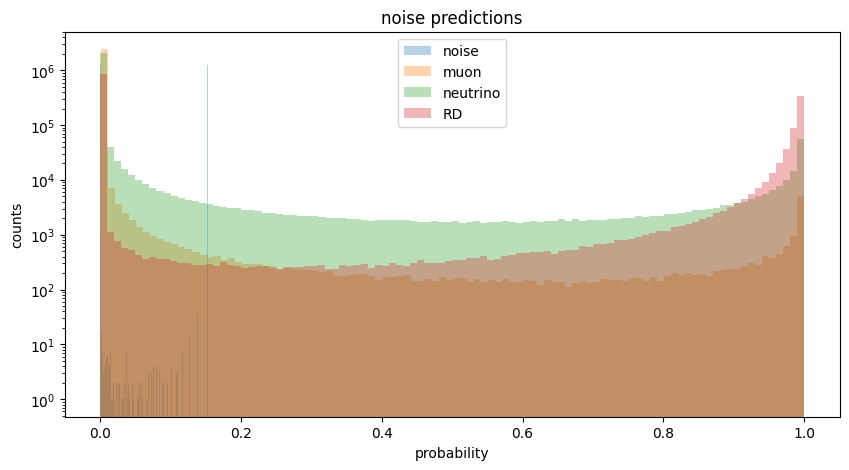

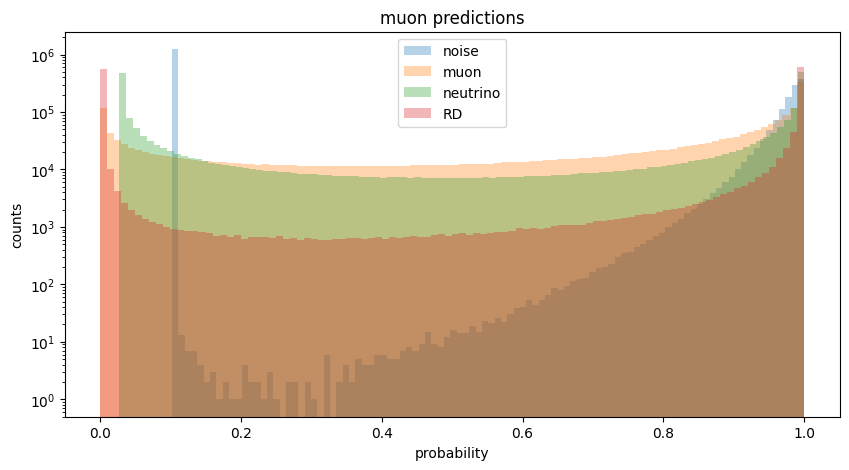

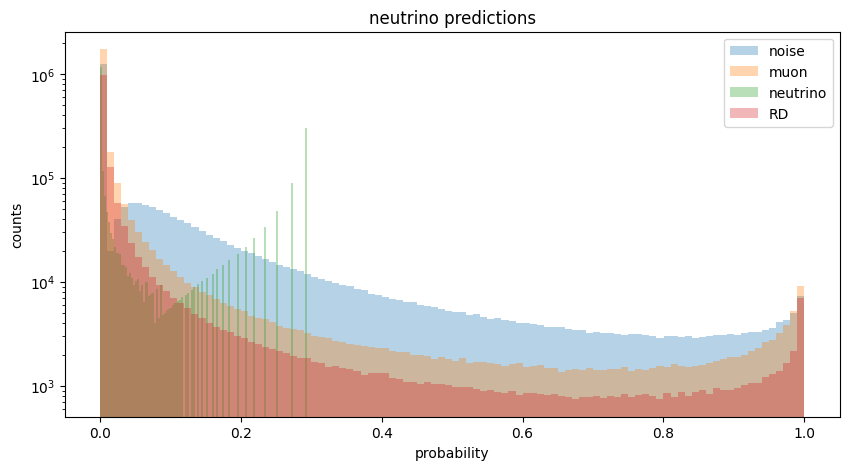

In [19]:
# loop over dataset
for key in keys:
    fig, ax = plt.subplots(figsize=[10, 5])
    # loop over noise/particle type
    for class_type, item in enumerate(keys):
        ax.hist(eval(f"{key}_probability")[item], bins=100, alpha=0.33, label=item);
    ax.set_title(f"{key} predictions")
    ax.set_xlabel("probability")
    ax.set_ylabel("counts")
    ax.hist(results_RD[f'pid_{key}_pred'], bins=100, alpha=0.33, label="RD")
    ax.set(yscale="log")
    ax.legend();

def to_multivariate_logit(p1,p2):
    """bivariate logit with common metrics"""
    try:
        sigma =
        rho =
        mu = 
        p1_logit = to_logit(p1)
        p2_logit = to_logit(p2)
        Q = (sigma**2 * (1-rho**2))**(-1) * ( (p1_logit-mu)**2 + (p2_logit-mu)**2 - 2*rho * (p1_logit-mu)*(p2_logit-mu))
        sub = (sigma**2 * np.sqrt(1-rho) * p1 * p2 * (1-p1)*(1-p2))
        upper = np.exp(-Q*0.5)
        logit = upper/sub
    except ZeroDivisionError:
        logit = 0
    if np.isinf(logit):
        logit = 0
    return logit